In [1]:
# cofing: utf-8
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# データの前処理
import os
import sklearn
import sklearn.model_selection
from tensorflow.keras.utils import to_categorical
batch_size = 100 # データの大きさ reshapeしてからshapeの形求める感じでやろう
timesteps = 256
input_dim = 3 # acc (x, y, z)
num_classes = 7 # 分類数

x_train, y_train, x_test, y_test = (1, 1, 1, 1)


In [3]:
# データの読み込み
home_dir = os.path.expanduser("~")
label_path = home_dir + "/Desktop/hasc_data/y_large3.csv"
data_path  = home_dir + "/Desktop/hasc_data/x_large3.csv"

label_df = pd.read_csv(label_path, index_col=0)
data_np  = np.loadtxt (data_path , delimiter=",").reshape(-1, timesteps, input_dim)

In [4]:
# label の取り扱い
labels = label_df["act"]

In [5]:
# データ分割
# TODO
# (xtrain, xtest, ytrain, ytest) = train_test_split(x, y) でできないか？
# データの正規化，標準化をもっときれいにできないか？
y_train, y_test = sklearn.model_selection.train_test_split(labels, test_size = 98, train_size=560, stratify=labels)

x_train = data_np[y_train.index]
x_test  = data_np[y_test.index]
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

num_classes = len(y_train[0])
print(num_classes, "classies validation")
batch_size = x_test.shape[0]

7 classies validation


In [6]:
#preprocessing
# TODO
# ここもっと綺麗にしたい
# dict使って，MMSとStdSをうまく使えるようにしたい
from sklearn.preprocessing import MinMaxScaler, StandardScaler

MMScaler =　MinMaxScaler()
StdScaler = StandardScaler()

x_test_mms = []
x_train_mms = []

for x in x_test:
    x = StdScaler.fit_transform(x)
    x_test_mms.append(x)
    
for  x in x_train:
    x = StdScaler.fit_transform(x)
    x_train_mms.append(x)

x_test_mms = np.array(x_test_mms)
x_train_mms = np.array(x_train_mms)

In [5]:
# TODO モデルを保存したdictを作ってうまく管理したい
# 今はモデル作ったやつをそのまま辞書の中に入れてるけど，コンパイルしてから入れたほうがいいかも？

models = {}

lstm_dontrun_input = Input( shape=( timesteps, input_dim ) )
lstm_dontrun_lstm1 = LSTM(units=256, activation="relu", kernel_initializer="he_normal", return_sequences=True, dropout=0.1)( lstm_dontrun_input )
lstm_dontrun_lstm2 = LSTM(units=128, activation="relu", kernel_initializer="he_normal", return_sequences=True, dropout=0.1)( lstm_dontrun_lstm1 )
lstm_dontrun_lstm3 = LSTM(units=64, activation="relu", kernel_initializer="he_normal",  return_sequences=True, dropout=0.1)( lstm_dontrun_lstm2 )
lstm_dontrun_lstm4 = LSTM(units=32, activation="relu", kernel_initializer="he_normal", dropout=0.1)( lstm_dontrun_lstm3 )
lstm_dontrun_dense = Dense(units=num_classes, activation="softmax")( lstm_dontrun_lstm4 )
model_lstm_dontrun = Model(inputs = lstm_dontrun_input, outputs=lstm_dontrun_dense, name="lstm_dontrun")
models["lstm_dontrun"] = model_lstm_dontrun

lstm_1_input = Input( shape=( timesteps, input_dim ) )
lstm_1_lstm = LSTM(units=32, activation="relu", kernel_initializer="he_normal",  return_sequences=True, dropout=0.1)( lstm_1_input )
lstm_1_dense = Dense(units=num_classes, activation="softmax")( lstm_1_lstm )
model_lstm_1 = Model(inputs = lstm_1_input, outputs = lstm_1_dense, name="lstm_1")
models["lstm_1"] = model_lstm_1

conv1_1_input = Input( shape=( timesteps, input_dim ) )
conv1_1_conv1 = Conv1D(filters=128, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_input)
conv1_1_pool1 = MaxPooling1D(4, padding='same')(conv1_1_conv1)
conv1_1_conv2 = Conv1D(filters=64, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_pool1)
conv1_1_pool2 = MaxPooling1D(1, padding='same')(conv1_1_conv2)
conv1_1_conv3 = Conv1D(filters=32, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_pool2)
conv1_1_conv4 = Conv1D(filters=16, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_conv3)
conv1_1_flatter = Flatten()(conv1_1_conv4)
conv1_1_dense = Dense(units=num_classes, activation="softmax")(conv1_1_flatter)
model_conv1_1 = Model(inputs=conv1_1_input, outputs=conv1_1_dense, name="conv1d_1")
models["conv1d_1"] = model_conv1_1


In [6]:
print("model list:")
for name in models.keys():
    print("・", name)

for model in models.values():
    print()
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    print()

model list:
・ lstm_dontrun
・ lstm_1
・ conv1d_1

Model: "lstm_dontrun"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 3)]          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256, 256)          266240    
_________________________________________________________________
lstm_6 (LSTM)                (None, 256, 128)          197120    
_________________________________________________________________
lstm_7 (LSTM)                (None, 256, 64)           49408     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 525,415
Trainable params: 525,415
Non-trainable params: 0


In [9]:
"""
model_to_dotがうまく動かないのでこのセルは実行しないこと

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog="dot", format="svg"))
"""

pass

In [10]:
# model_lstm.fit(x_train_mms, y_train, batch_size=batch_size//20, epochs=50, verbose=1, callbacks=[EarlyStopping(verbose=1)], validation_data=(x_test_mms, y_test))
result = model_conv1d.fit(x_train_mms, y_train, batch_size=batch_size//40, epochs=50, verbose=2, validation_data=(x_test_mms, y_test))

Train on 560 samples, validate on 98 samples
Epoch 1/50
560/560 - 2s - loss: 1.9196 - acc: 0.1679 - val_loss: 1.8115 - val_acc: 0.1939
Epoch 2/50
560/560 - 2s - loss: 1.8008 - acc: 0.2375 - val_loss: 1.7835 - val_acc: 0.1531
Epoch 3/50
560/560 - 2s - loss: 1.7724 - acc: 0.2250 - val_loss: 1.7813 - val_acc: 0.2041
Epoch 4/50
560/560 - 2s - loss: 1.7445 - acc: 0.2375 - val_loss: 1.6290 - val_acc: 0.2959
Epoch 5/50
560/560 - 2s - loss: 1.7005 - acc: 0.2554 - val_loss: 1.7297 - val_acc: 0.2449
Epoch 6/50
560/560 - 2s - loss: 1.6549 - acc: 0.2982 - val_loss: 1.6554 - val_acc: 0.2551
Epoch 7/50
560/560 - 2s - loss: 1.5921 - acc: 0.3375 - val_loss: 1.6333 - val_acc: 0.3163
Epoch 8/50
560/560 - 2s - loss: 1.4291 - acc: 0.4125 - val_loss: 1.5410 - val_acc: 0.3061
Epoch 9/50
560/560 - 2s - loss: 1.2990 - acc: 0.5107 - val_loss: 1.6548 - val_acc: 0.3469
Epoch 10/50
560/560 - 2s - loss: 1.1060 - acc: 0.5589 - val_loss: 1.8007 - val_acc: 0.2857
Epoch 11/50
560/560 - 2s - loss: 0.8740 - acc: 0.6732 

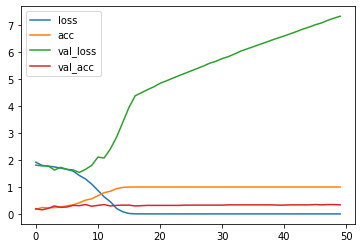

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
for key in  result.history.keys():
    plt.plot(result.history[key], label = key)
    plt.legend()

In [16]:
evals = model_conv1d.evaluate(x_test, y_test)
print("loss", evals[0])
print("acc",  evals[1])

98/98 [==============================] - 0s 356us/sample - loss: 8.1799 - acc: 0.2041
loss 8.179937206968969
acc 0.20408164
